In [117]:
import json
import os
import sys
import numpy as np
import scipy.interpolate as spi
import matplotlib.pyplot as plt
import matplotlib.widgets as wgt
import matplotlib.patches as pat

data = []
# Open the file and replace single quotes with double quotes

dataname = 'metal_1p'
datadate = '2024-08-28_14-35-07'
folder = r'../log/'+dataname+r'/'+dataname
sourcepath = folder + r'_pymmw_' + datadate + '.log'
processedpath = folder + r'.npy'

with open(sourcepath, 'r') as file:
    for line in file:
        # Replace single quotes with double quotes
        corrected_line = line.replace("'", '"')
        
        # Parse the JSON object
        try:
            data.append(json.loads(corrected_line.strip()))
            # print(data)  # Process each JSON object as needed
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON: {e}")

In [118]:
def allkeys(d, i = 0):
    if(type(d) == dict):       
        for k in d.keys():
            print("\t"*i, k, type(d[k]))
            allkeys(d[k], i+1)

In [119]:
allkeys(data[0])

 ts <class 'int'>
 dataFrame <class 'dict'>
	 header <class 'dict'>
		 version <class 'int'>
		 length <class 'int'>
		 platform <class 'int'>
		 number <class 'int'>
		 time <class 'int'>
		 objects <class 'int'>
		 blocks <class 'int'>
		 subframe <class 'int'>
	 range_profile <class 'list'>
	 noise_profile <class 'list'>
	 azimuth_static <class 'list'>
	 range_doppler <class 'list'>


In [120]:
data[0]["dataFrame"]["header"]

{'version': 3040003,
 'length': 17504,
 'platform': 101843,
 'number': 1,
 'time': 265232496,
 'objects': 13,
 'blocks': 4,
 'subframe': 0}

In [121]:
filtered_data = []

for i in range(len(data)):
    try:
        if (
            len(data[i]["dataFrame"]["range_profile"]) == 256 and
            len(data[i]["dataFrame"]["noise_profile"]) == 256 and
            len(data[i]["dataFrame"]["azimuth_static"]) == 4096 and
            len(data[i]["dataFrame"]["range_doppler"]) == 4096
        ):
            filtered_data.append(data[i])
    except KeyError as e:
        print(f"Key error: {e} in element {i}")

print('dropped', len(data)-len(filtered_data))
# After filtering
data = filtered_data

dropped 0


In [122]:
from matplotlib import pyplot as plt
import numpy as np

338


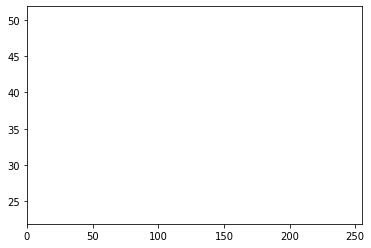

In [123]:
import matplotlib.animation as animation

# Set up the figure and axis
fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)

# Set up plot limits
ax.set_xlim(0, len(data[0]["dataFrame"]["range_profile"]) - 1)
ax.set_ylim(min(min(d["dataFrame"]["range_profile"]) for d in data), 
            max(max(d["dataFrame"]["range_profile"]) for d in data))

# Initialization function
def init():
    line.set_data([], [])
    return line,

# Update function for animation
def update(i):
    y_data = data[i]["dataFrame"]["range_profile"]
    x_data = np.arange(len(y_data))
    line.set_data(x_data, y_data)
    return line,

print(len(data))
# Create animation
ani = animation.FuncAnimation(fig, update, frames=len(data), init_func=init, blit=True, repeat=False)

# Display animation
plt.show()


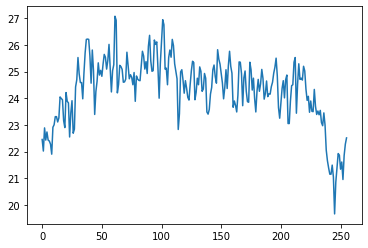

In [124]:
plt.plot(data[0]["dataFrame"]["noise_profile"])

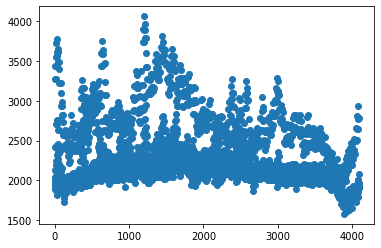

In [125]:
plt.scatter(np.arange(4096), data[0]["dataFrame"]["range_doppler"])

In [126]:
import scipy.interpolate as spi

In [127]:
tx_azimuth_antennas = 2
rx_antennas = 4

range_bins = 256 
angle_bins = 64

range_res = 11.6/range_bins
range_bias = 0.07


t = np.array(range(-angle_bins//2 + 1, angle_bins//2)) * (2 / angle_bins)
t = np.arcsin(t)
r = np.array(range(range_bins)) * range_res

range_depth = range_bins * range_res
range_width, grid_res = range_depth / 2, 400

xi = np.linspace(-range_width, range_width, grid_res)
yi = np.linspace(0, range_depth, grid_res)
xi, yi = np.meshgrid(xi, yi)

x = np.array([r]).T * np.sin(t)
y = np.array([r]).T * np.cos(t)
y = y - range_bias

In [128]:
def setup_graph():
    fig = plt.figure(figsize=(6, 6))
    ax = plt.subplot(1, 1, 1)


    cm = ax.imshow(((0,)*grid_res,) * grid_res, cmap=plt.cm.jet, extent=[-range_width, +range_width, 0, range_depth], alpha=0.95)

    cursor = wgt.Cursor(ax, useblit=True, color='white', linewidth=1)
            
    fig.canvas.manager.set_window_title('...')


    # move_figure(fig, (0 + 45*3, 0 + 45*3))
    # fig.tight_layout(pad=2)
                            
    ax.set_title('Azimuth-Range FFT Heatmap [{};{}]'.format(angle_bins, range_bins), fontsize=10)
    ax.set_xlabel('Lateral distance along [m]')
    ax.set_ylabel('Longitudinal distance along [m]')

    ax.plot([0, 0], [0, range_depth], color='white', linewidth=0.5, linestyle=':', zorder=1)
    ax.plot([0, -range_width], [0, range_width], color='white', linewidth=0.5, linestyle=':', zorder=1)
    ax.plot([0, +range_width], [0, range_width], color='white', linewidth=0.5, linestyle=':', zorder=1)    

    ax.set_ylim([0, +range_depth])
    ax.set_xlim([-range_width, +range_width])

    for i in range(1, int(range_depth)+1):
        ax.add_patch(pat.Arc((0, 0), width=i*2, height=i*2, angle=90, theta1=-90, theta2=90, color='white', linewidth=0.5, linestyle=':', zorder=1))

    # fig.canvas.mpl_connect('button_press_event', onclick)
    return fig,ax,cm

In [129]:
def process(data):
    a = data['azimuth_static']

    a = np.array([a[i] + 1j * a[i+1] for i in range(0, len(a), 2)])
    a = np.reshape(a, (range_bins, tx_azimuth_antennas * rx_antennas))
    a = np.fft.fft(a, angle_bins)

    a = np.abs(a)
    a = np.fft.fftshift(a, axes=(1,))  # put left to center, put center to right       
    a = a[:,1:]  # cut off first angle bin

    zi = spi.griddata((x.ravel(), y.ravel()), a.ravel(), (xi, yi), method='linear')
    zi = zi[:-1,:-1]
    
    return zi[::-1,::-1]

In [130]:
processed_data = np.array([process(data[i]["dataFrame"]) for i in range(len(data))])
processed_data.shape

(338, 399, 399)

In [131]:
np.save(processedpath, processed_data)

In [132]:
#sanity test for storing array
processed_data2 = np.load(processedpath)
np.array_equal(processed_data, processed_data2, equal_nan=True)

True

In [133]:
heat_mode, heat_choice = ('rel', 'abs'), 1

from functools import partial
def animate(i, dataset,cm):
    print(i)
    
    zi = dataset[i]

    cm.set_array(zi)  # rotate 180 degrees
    if heat_mode[heat_choice] == 'rel':
        cm.autoscale()  # reset colormap
    elif heat_mode[heat_choice] == 'abs':
        cm.set_clim(0, 256**2 // 2)  # reset colormap
    return [cm]

def save_animation(fig, dataset, n_frames, filename):
    fig,_,cm = setup_graph()
    # Create animation
    ani = animation.FuncAnimation(fig, partial(animate,dataset = dataset,cm=cm)
                                ,frames=n_frames #len(data)
                                , blit=True)
    # Save animation to a file
    writergif = animation.PillowWriter(fps=4)
    ani.save(f'{filename}.gif',writer=writergif)

0
0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
27

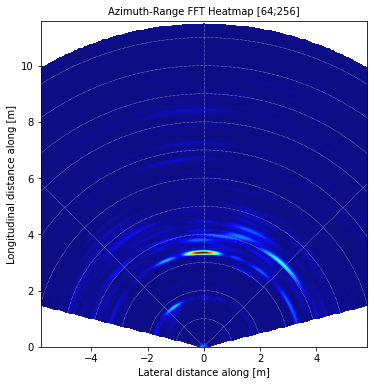

In [134]:
save_animation(fig, processed_data, len(processed_data), folder + '_original')
plt.show()

In [135]:
#apply guassian blur IN TIME!!!
from scipy.ndimage import gaussian_filter1d
blurred_data = np.apply_along_axis(lambda x: gaussian_filter1d(x, 1), 0, processed_data)
blurred_data.shape

(338, 399, 399)

0
0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
27

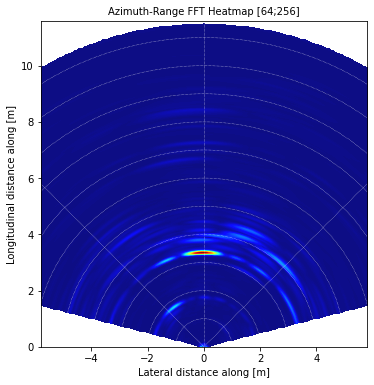

In [136]:
save_animation(fig, blurred_data, len(processed_data), folder +'_blurred')
plt.show()

In [137]:
from time import strftime, localtime

for d in data:
    print(strftime('%d-%m-%Y %H:%M:%S', localtime(d["ts"]/1000)), d["ts"]%1000, sep = ".")



28-08-2024 14:35:09.135
28-08-2024 14:35:09.384
28-08-2024 14:35:09.635
28-08-2024 14:35:09.884
28-08-2024 14:35:10.134
28-08-2024 14:35:10.385
28-08-2024 14:35:10.635
28-08-2024 14:35:10.884
28-08-2024 14:35:11.135
28-08-2024 14:35:11.385
28-08-2024 14:35:11.635
28-08-2024 14:35:11.885
28-08-2024 14:35:12.134
28-08-2024 14:35:12.385
28-08-2024 14:35:12.635
28-08-2024 14:35:12.885
28-08-2024 14:35:13.134
28-08-2024 14:35:13.385
28-08-2024 14:35:13.635
28-08-2024 14:35:13.884
28-08-2024 14:35:14.135
28-08-2024 14:35:14.385
28-08-2024 14:35:14.635
28-08-2024 14:35:14.885
28-08-2024 14:35:15.134
28-08-2024 14:35:15.384
28-08-2024 14:35:15.635
28-08-2024 14:35:15.885
28-08-2024 14:35:16.134
28-08-2024 14:35:16.385
28-08-2024 14:35:16.635
28-08-2024 14:35:16.884
28-08-2024 14:35:17.135
28-08-2024 14:35:17.385
28-08-2024 14:35:17.635
28-08-2024 14:35:17.885
28-08-2024 14:35:18.134
28-08-2024 14:35:18.385
28-08-2024 14:35:18.635
28-08-2024 14:35:18.884
28-08-2024 14:35:19.135
28-08-2024 14:35